In [1]:
import argparse
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import mdtraj as md
import MDAnalysis as mda
from geom2vec.data import Preprocessing
from geom2vec import create_model
from geom2vec.data import extract_mda_info, extract_mda_info_folder, infer_traj

topology_file = "/project/dinner/anton_data/DESRES-Trajectory_2F4K-0-protein/villin.pdb"
trajectory_folder = "/project/dinner/anton_data/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein"

position_list, atomic_numbers, segment_counts, file_paths, md_objects = extract_mda_info_folder(
    folder = trajectory_folder,
    top_file = topology_file,
    stride = 2,
    selection = 'prop mass > 1.1', # by default, we only consider heavy atoms, this is the default selection
)

from geom2vec.data import Preprocessing

folder_path = '/project/dinner/zpengmei/geom2vec/sep_notebooks/global_token/villin_stride2'
preprocess = Preprocessing(dtype=torch.float32,num_tokens=len(segment_counts),backend='mda',stride=2)
graph_features = preprocess.load_dataset(folder_path,mmap_mode='r')
ca_coords = preprocess._extract_ca_coords(md_objects)
ca_pw_dist = preprocess._extract_ca_pairwise_dist(md_objects)

/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-p

Processing 2F4K-0-protein-000.dcd


/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Processing 2F4K-0-protein-001.dcd
Processing 2F4K-0-protein-002.dcd
Processing 2F4K-0-protein-003.dcd
Processing 2F4K-0-protein-004.dcd
Processing 2F4K-0-protein-005.dcd
Processing 2F4K-0-protein-006.dcd
Processing 2F4K-0-protein-007.dcd
Processing 2F4K-0-protein-008.dcd
Processing 2F4K-0-protein-009.dcd
Processing 2F4K-0-protein-010.dcd
Processing 2F4K-0-protein-011.dcd
Processing 2F4K-0-protein-012.dcd
Processing 2F4K-0-protein-013.dcd
Processing 2F4K-0-protein-014.dcd
Processing 2F4K-0-protein-015.dcd
Processing 2F4K-0-protein-016.dcd
Processing 2F4K-0-protein-017.dcd
Processing 2F4K-0-protein-018.dcd
Processing 2F4K-0-protein-019.dcd
Processing 2F4K-0-protein-020.dcd
Processing 2F4K-0-protein-021.dcd
Processing 2F4K-0-protein-022.dcd
Processing 2F4K-0-protein-023.dcd
Processing 2F4K-0-protein-024.dcd
Processing 2F4K-0-protein-025.dcd
Processing 2F4K-0-protein-026.dcd
Processing 2F4K-0-protein-027.dcd
Processing 2F4K-0-protein-028.dcd
Processing 2F4K-0-protein-029.dcd
Processing 2F4

Extracting Ca pairwise distances (MDAnalysis): 100%|████████████████████████████████████████████████| 63/63 [00:27<00:00,  2.28it/s]

There are 595 pairs of CA pairwise distances as global features.


In [2]:
from geom2vec.data.util import packing_features

graph_features = torch.cat(graph_features,dim=0)
ca_coords = torch.cat(ca_coords,dim=0)
ca_pw_dist = torch.cat(ca_pw_dist,dim=0)

packed_features = packing_features(graph_features=graph_features,ca_coords=ca_coords,
global_features=ca_pw_dist,num_tokens=35)

In [3]:
# split the data into training and validation
len_traj = len(graph_features)
train_size = int(0.5 * len_traj)

train_graph_features = graph_features[:train_size]
val_graph_features = graph_features[train_size:]

train_ca_coords = ca_coords[:train_size]
val_ca_coords = ca_coords[train_size:]

train_ca_pw_dist = ca_pw_dist[:train_size]
val_ca_pw_dist = ca_pw_dist[train_size:]

In [4]:
train_dataset = preprocess.create_time_lagged_dataset(data=train_ca_pw_dist,lag_time=25)
val_dataset = preprocess.create_time_lagged_dataset(data=val_ca_pw_dist,lag_time=25)

train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=2000, shuffle=True)

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# create the model
device = "cuda" if torch.cuda.is_available() else "cpu"
net = MLP(input_size=595, hidden_size=128, output_size=10).to(device)

In [6]:
from geom2vec.downstream_models import VAMPNet

model = VAMPNet(
    lobe=net,
    learning_rate=2e-4,
    optimizer='AdamAtan2',
    device=device
)

start = time.time()

model.fit(train_loader,
    n_epochs=20,
    validation_loader=validation_loader,
    progress=tqdm,
    train_patience=100,
    train_valid_interval=25,
    valid_patience=5,
)
end = time.time()

epoch:   0%|                                                                                                 | 0/20 [00:00<?, ?it/s]

0 3.1341066360473633


0 3.910196542739868


epoch:   5%|████▍                                                                                    | 1/20 [00:02<00:55,  2.94s/it]

0 4.4723405838012695


1 4.815508842468262


1 5.036474227905273


epoch:  10%|████████▉                                                                                | 2/20 [00:05<00:47,  2.65s/it]

1 5.173248767852783


2 5.271198272705078


2 5.429292678833008


epoch:  15%|█████████████▎                                                                           | 3/20 [00:07<00:43,  2.56s/it]

2 5.5348381996154785


3 5.631668567657471


3 5.72412109375


epoch:  20%|█████████████████▊                                                                       | 4/20 [00:10<00:40,  2.51s/it]

3 5.882826328277588


4 5.956140995025635


4 5.943090438842773


epoch:  25%|██████████████████████▎                                                                  | 5/20 [00:12<00:37,  2.47s/it]

4 6.014955520629883


5 6.054412841796875


5 6.101900100708008


5 6.0468220710754395


epoch:  30%|██████████████████████████▋                                                              | 6/20 [00:15<00:35,  2.54s/it]

6 5.989627361297607


6 5.948345184326172


6 6.203122615814209


epoch:  35%|███████████████████████████████▏                                                         | 7/20 [00:18<00:34,  2.69s/it]

6 6.260508060455322


7 6.13041877746582


7 6.411407947540283


epoch:  40%|███████████████████████████████████▌                                                     | 8/20 [00:20<00:31,  2.59s/it]

7 6.215816020965576


8 6.184633255004883


8 6.132320880889893


epoch:  45%|████████████████████████████████████████                                                 | 9/20 [00:23<00:27,  2.53s/it]

8 6.2714667320251465


9 6.22698450088501


9 6.461400985717773


epoch:  50%|████████████████████████████████████████████                                            | 10/20 [00:25<00:24,  2.49s/it]

9 6.240087509155273


 23%|█████████████████████▋                                                                         | 18/79 [00:00<00:02, 23.95it/s]
                                                                                                                                    

10 6.260099411010742
Training patience reached at epoch 10


In [8]:
from sklearn.cluster import MiniBatchKMeans

cvs = model.transform(ca_pw_dist,lag_time=25)
cluster = MiniBatchKMeans(n_clusters=100, n_init=100, random_state=0, batch_size=4096)
cluster.fit(cvs)
initial_label = cluster.predict(cvs)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:00<00:00, 4812.86it/s]


In [9]:
traj_length = len(packed_features)
train_trajs = packed_features[:int(traj_length * 0.5)]
train_labels = torch.tensor(initial_label[:int(traj_length * 0.5)]).long()
test_trajs = packed_features[int(traj_length * 0.5):]
test_labels = torch.tensor(initial_label[int(traj_length * 0.5):]).long()

train_dataset = preprocess.create_spib_dataset(data_list=[train_trajs], label_list=[train_labels], weight_list=None, lag_time=25,output_dim=100)
test_dataset = preprocess.create_spib_dataset(data_list=[test_trajs], label_list=[test_labels], weight_list=None, lag_time = 25,output_dim=100)

In [11]:
from geom2vec.downstream_models.lobe_flat import Lobe
from geom2vec.downstream_models.SPIB.spib import SPIBModel

device = "cuda" if torch.cuda.is_available() else "cpu"

net = Lobe(
    hidden_channels=64,
    intermediate_channels=64,
    output_channels=64,
    num_layers=3,
    batch_norm=True,
    vector_feature=True,
    mlp_dropout=0.2,
    dropout=0.1,
    mlp_out_activation=None,
    device=device,
    token_mixer= 'submixer-gvp',
    pooling='mean',
    num_tokens=35,
    num_mixer_layers=4,
    token_dim=40,
    use_global=True,
    global_dim=595,
    gvp_post_mixer_layers=2,
).to(device)


batch_size = 1000 # not necessarily to be this small

IB = SPIBModel(output_dim=100, data_shape=(9660,), z_dim=2,  lagtime=25,
          beta=1e-3, learning_rate=2e-4, device=device,UpdateLabel=True,
          neuron_num1=64, neuron_num2=64, encoder=net).to(device)

IB.fit(train_dataset, test_dataset, batch_size=batch_size, tolerance=0.05, patience=5, refinements=5, index=0)

Epoch 1:	Time 41.12 s
Loss (train): 4.352262	KL loss (train): 0.454093
Reconstruction loss (train): 4.351810
Loss (test): 4.100240	KL loss (test): 1.519041
Reconstruction loss (test): 4.098724
State population:
[0.         0.01241781 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.14775218
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.24761711 0.         0.         0.         0.
 0.         0.         0.5466448  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0073462
 0.    

SPIBModel(
  (encoder): Lobe(
    (dropout): Dropout(p=0.2, inplace=False)
    (input_projection): EquivariantScalar(
      (output_network): ModuleList(
        (0): GatedEquivariantBlock(
          (vec1_proj): Linear(in_features=64, out_features=64, bias=False)
          (vec2_proj): Linear(in_features=64, out_features=64, bias=False)
          (update_net): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): SiLU()
            (2): Linear(in_features=64, out_features=128, bias=True)
          )
          (act): SiLU()
        )
        (1): GatedEquivariantBlock(
          (vec1_proj): Linear(in_features=64, out_features=64, bias=False)
          (vec2_proj): Linear(in_features=64, out_features=64, bias=False)
          (update_net): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): SiLU()
            (2): Linear(in_features=64, out_features=128, bias=True)
          )
        )
      )
  

In [17]:
labels, all_prediction, all_z_mean, all_z_logvar = IB.transform(packed_features, batch_size=2048, to_numpy=True)

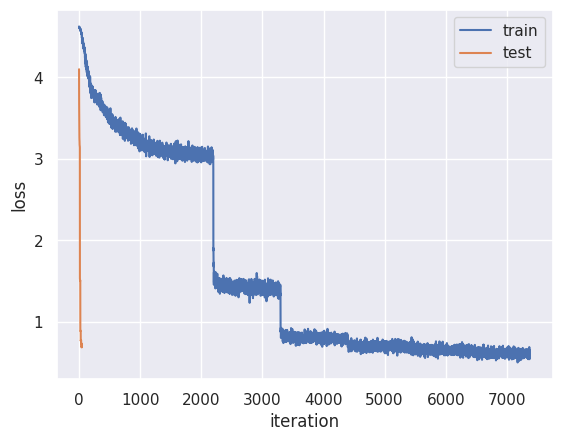

In [14]:
# plot the training curves
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

train_loss = np.array(IB.train_loss_history)[:,1]
test_loss = np.array(IB.test_loss_history)[:,1]

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()


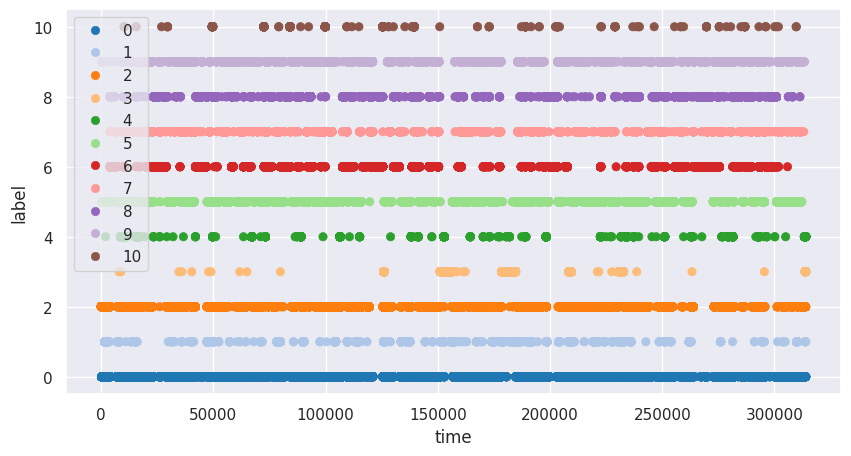

In [22]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=np.arange(len(labels)),y=labels,hue=labels,palette='tab20',edgecolor=None)
plt.xlabel('time')
plt.ylabel('label')
plt.show()

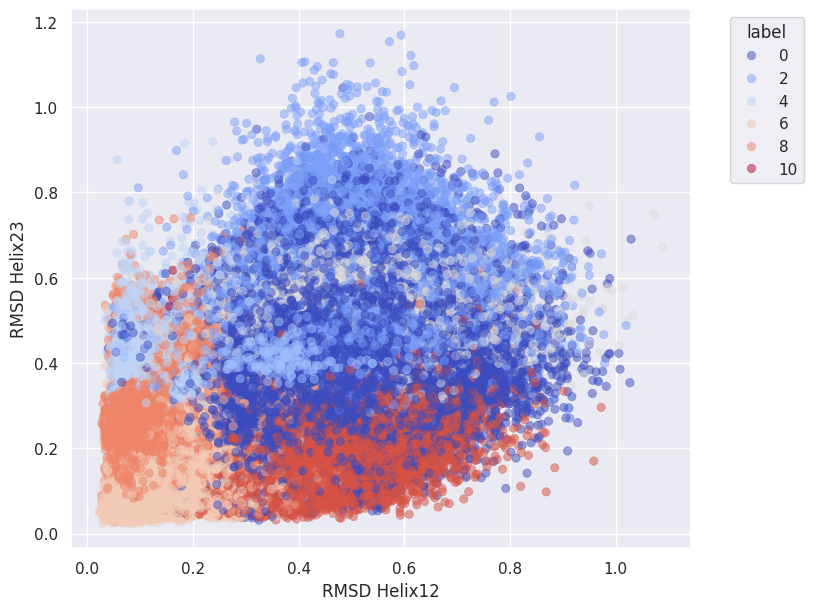

In [28]:
# plot the labels on RMSD CV1 and CV2

rmsd_cv1 = np.load('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/helix12_rmsd.npy')[::2]
rmsd_cv2 = np.load('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/helix23_rmsd.npy')[::2]

plt.figure(figsize=(8,7))
sns.scatterplot(x=rmsd_cv1,y=rmsd_cv2,hue=labels,palette='coolwarm',edgecolor=None,alpha=0.5)
plt.xlabel('RMSD Helix12')
plt.ylabel('RMSD Helix23')
plt.legend(title='label',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [48]:
# save all the results to /project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin
np.save('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin_labels.npy',labels)
np.save('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin_prediction.npy',all_prediction)
np.save('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin_z_mean.npy',all_z_mean)
np.save('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin_z_logvar.npy',all_z_logvar)

# save the model
torch.save(IB, '/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin_model.pth')

In [85]:
np.unique(labels,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([104107,   6100,  30899,  12823,   3088,  46398,  56258,   7590,
         19539,  26453,    699]))

In [117]:
# count the percentage of each label
unique, counts = np.unique(labels,return_counts=True)
percentage = counts / len(labels)
percentage


array([0.33159953, 0.0194296 , 0.09841888, 0.04084356, 0.00983584,
       0.14778598, 0.17919186, 0.02417552, 0.06223523, 0.08425757,
       0.00222644])

In [115]:
# use the mdtraj save the frame to pdb

traj = md.load(file_paths[9], top=topology_file,stride=2)

# save the 214 frame to pdb
traj[4544].save_pdb('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin/label10_frame.pdb')

In [116]:
# visualize the frame using py3Dmol
import py3Dmol


# color by residue type
view = py3Dmol.view(width=800,height=600)
view.addModel(open('/project/dinner/zpengmei/geom2vec/sep_notebooks/spib/villin/label10_frame.pdb').read(),'pdb')
# show ribbon not atoms, colored by residue
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.